## パラメータの最適化

### 確率的勾配降下法（SGD）
* 各地点で最も傾きが急な方向に進む
* 勾配の方向と最小値の方向が一致しない場合非効率な探索になる

### Momentum
* モーメンタムとは運動量のこと
* 球体を斜面に置いた時、勾配方向にチカラを受けて加速していく物理法則を最適化アルゴリズムとして取り入れたもの
* SGDより非効率さを軽減できる（らしい）
![momentum](momentum.png)

### AdaGrad
* パラメータの要素ごとに適応的に学習係数を調整しながら学習を進める方法
* 始めは学習係数を大きくして1ステップあたりの更新量を大きくとり、徐々に学習係数を小さくして慎重に学習を進めるようにする
* 具体的には以下のように実現する：
    - 過去の勾配を2乗和で保持し続ける（2乗和なので単調増加し続ける）
    - 過去の勾配を2乗和の平方根で学習率を割ることで徐々に学習のスケールが小さくなるようになっている

![AdaGrad](AdaGrad.png)

### Adam
* MomentumとAdaGradを融合したような手法
    * ただしオリジナルに比べて指数移動平均を使用しているため、より直近の値の影響が大きくなるようになっている。
* ハイパーパラメータの「バイアスの補正」も行える（←これ検証出来ず。扱うか相談したいです）

* 学習率
$$ {\rm{lr}}_t = {\rm{lr}} * \frac{\sqrt{1-{\beta}_2^i}}{1 - {\beta}_1^i} $$

* Momentum
$$ m_n = m_{n-1} + (1 - \beta_1)  * ( \frac{\partial L}{\partial w} - m_{n-1} )$$
$$ \ \ \ \   = \beta_1 * m_{n-1} + (1 - \beta_1)  *  \frac{\partial L}{\partial w} $$

* 学習率調整（AdaGrad）
$$ v_n = v_{n-1} + (1 - \beta_2)  * ((\frac{\partial L}{\partial w} )^2 - v_{n-1} )$$
$$ \ \ \ \   = \beta_2 * v_{n-1} + (1 - \beta_2)  *  (\frac{\partial L}{\partial w})^2 $$

* パラメータ更新
$$ w_n = w_{n-1} - {\rm{lr}}_t * \frac{1}{\sqrt{v_n + \epsilon}} * m_n$$

![](Adam.png)

# 重みの初期値

## 重みは0でよいのか?

* 重みが小さくなるように学習することで汎化性能が向上する（Weight decay : 荷重減衰）
* そのためには初期値も小さい値から始めた方が効率が良い
* しかし、オールゼロは悪いアイデア（より正確にはすべて同じ値にするのがよくない）
* これは逆伝播の際にすべてのパラメータが同じ値にしか更新されないためたくさんの重み（ニューロン）を持たせる意味がなくなるため

⇒初期値は小さい値をランダムで与えよう

## 重みの初期値と隠れ層のアクティベーション分布

* 重みの初期値の与え方がアクティベーション（活性化関数後の出力データ）の分布に影響する

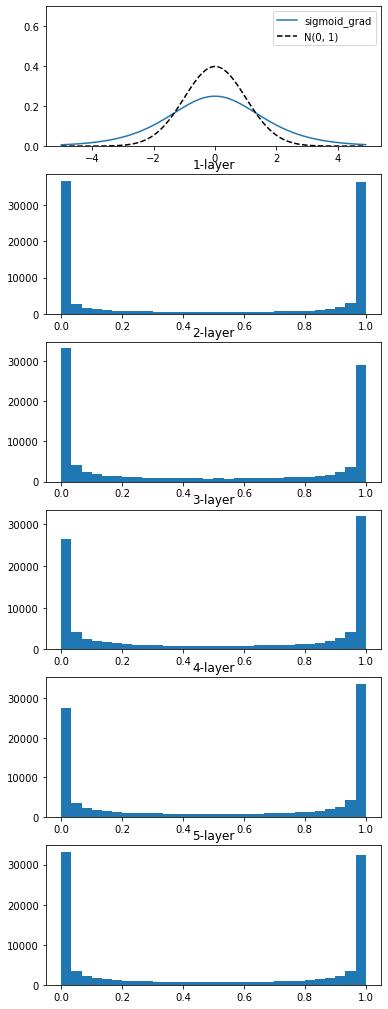

In [1]:
###############################################
# アクティベーション（活性化関数後の出力値）分布 #
# パターン１:標準偏差が大きくて勾配消失         #
#         ⇒0と1に寄っていく（勾配消失していく) #
###############################################

import sys, os
from pathlib import Path
sys.path.append(os.path.join(os.path.join(Path().resolve(), '..'), '..'))  # 親ディレクトリの親ディレクトリのファイルをインポートするための設定
import numpy as np
import math
from matplotlib import pyplot as plt
from common.presentation.functions import sigmoid, sigmoid_grad

std  = 1                       # 標準偏差
x = np.random.randn(1000, 100) # 1000*100のndarrayを生成(100次元のデータを1000個生成)
node_num = 100                 # 各中間層のノード数
hidden_layer_size = 5          # 中間層の数
activations = {}               # アクティベーションを格納

######################### フォワード #########################
for i in range(hidden_layer_size):
    # 2層目以降は前層のアクティベーションを取得
    if i != 0:
        x = activations[i-1]
    
    # 標準正規分布に従う重みを生成
    w = np.random.randn(node_num, node_num) * std

    # 線形和を計算
    z = np.dot(x, w)
    # アクティベーションを計算
    a = sigmoid(z)
    # アクティベーションを格納
    activations[i] = a

################# シグモイド関数と初期値の分布 #################
plt.figure(figsize=(6,3*(1+len(activations))))

def normal(x, mu=0, std=1):
    return np.exp(-(x-mu)**2/(2*std**2)) / np.sqrt(2*np.pi)

x = np.arange(-5.0, 5.0, 0.1)
y1 = sigmoid_grad(x)
y2 = normal(x,std=std)
plt.subplot(1+len(activations), 1, 1)
plt.plot(x, y1, label='sigmoid_grad')
plt.plot(x, y2, 'k--', label=f'N(0, {std})')
plt.legend()
plt.ylim(0, 0.7)

###################### ヒストグラム描画 ######################
for i, a in activations.items():
    plt.subplot(1+len(activations), 1, i+2)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

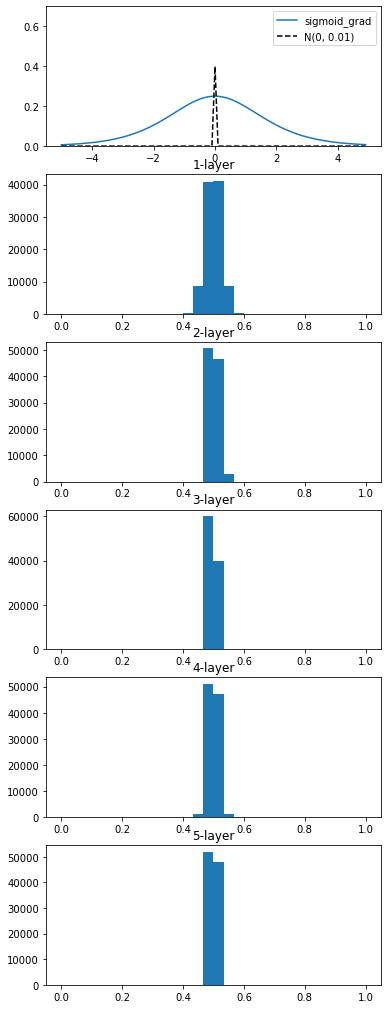

In [2]:
###############################################
# アクティベーション（活性化関数後の出力値）分布 #
# パターン2:標準偏差が小さくて表現の制限        #
#         ⇒0.5に寄っていく（表現が偏っていく)  #
###############################################

import sys, os
from pathlib import Path
sys.path.append(os.path.join(os.path.join(Path().resolve(), '..'), '..'))  # 親ディレクトリの親ディレクトリのファイルをインポートするための設定
import numpy as np
import math
from matplotlib import pyplot as plt
from common.presentation.functions import sigmoid, sigmoid_grad

std  = 0.01                    # 標準偏差
x = np.random.randn(1000, 100) # 1000*100のndarrayを生成(100次元のデータを1000個生成)
node_num = 100                 # 各中間層のノード数
hidden_layer_size = 5          # 中間層の数
activations = {}               # アクティベーションを格納

######################### フォワード #########################
for i in range(hidden_layer_size):
    # 2層目以降は前層のアクティベーションを取得
    if i != 0:
        x = activations[i-1]
    
    # 標準正規分布に従う重みを生成
    w = np.random.randn(node_num, node_num) * std

    # 線形和を計算
    z = np.dot(x, w)
    # アクティベーションを計算
    a = sigmoid(z)
    # アクティベーションを格納
    activations[i] = a

################# シグモイド関数と初期値の分布 #################
plt.figure(figsize=(6,3*(1+len(activations))))

def normal(x, mu=0, std=1):
    return np.exp(-(x-mu)**2/(2*std**2)) / np.sqrt(2*np.pi)

x = np.arange(-5.0, 5.0, 0.1)
y1 = sigmoid_grad(x)
y2 = normal(x,std=std)
plt.subplot(1+len(activations), 1, 1)
plt.plot(x, y1, label='sigmoid_grad')
plt.plot(x, y2, 'k--', label=f'N(0, {std})')
plt.legend()
plt.ylim(0, 0.7)

###################### ヒストグラム描画 ######################
for i, a in activations.items():
    plt.subplot(1+len(activations), 1, i+2)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

### Xavierの初期値
* Xavier Glorotらの論文で推奨される初期値の与え方
* 現在の一般的なニューラルネットワークのフレームワークで標準的に使用される
* 各層のアクティベーション分布に同じ広がりを持たせるための適切な重みのスケールとしてN(0, 1/√n) (nは前層のノード数)を推奨している

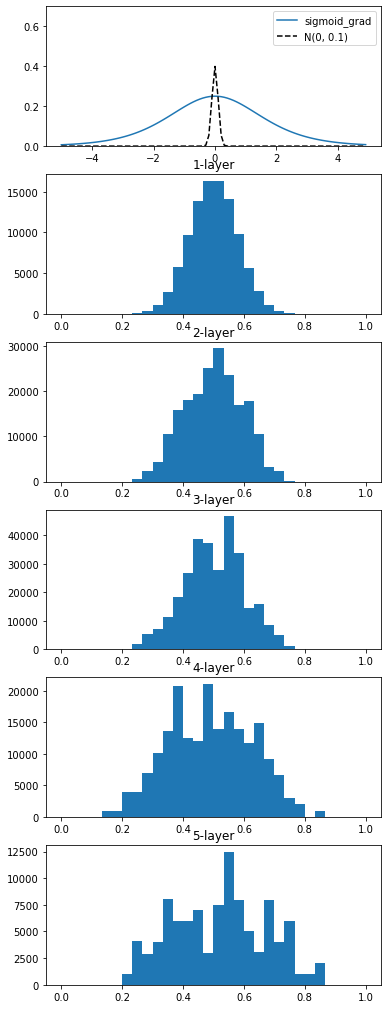

In [3]:
###############################################
# アクティベーション（活性化関数後の出力値）分布 #
# パターン3:Xavierの初期値                     #
###############################################

import sys, os
from pathlib import Path
sys.path.append(os.path.join(os.path.join(Path().resolve(), '..'), '..'))  # 親ディレクトリの親ディレクトリのファイルをインポートするための設定
import numpy as np
import math
from matplotlib import pyplot as plt
from common.presentation.functions import sigmoid, sigmoid_grad
import common.presentation.debug as debug

debug.isDebugMode = False

std  = 0.1                                  # 標準偏差
x = np.random.randn(1000, 100)              # 1000*100のndarrayを生成(100次元のデータを1000個生成)
debug.debugprt(x.shape, "x.shape")
node_num = np.array([100,200,300,200,100])  # 各中間層のノード数
hidden_layer_size = 5                       # 中間層の数
activations = {}                            # アクティベーションを格納
w = {}

######################### フォワード #########################
for i in range(hidden_layer_size):
    if i == 0:
        # 正規分布N(0, 1/np.sqrt(x.shape[0]))に従う重みを生成
        w = np.random.randn(x.shape[1], node_num[i]) / np.sqrt(x.shape[0])  # Xavierの初期値:前層のノード数の平方根で除する
    else:
        # 2層目以降は前層のアクティベーションを取得
        x = activations[i-1]
        # 正規分布N(0, 1/np.sqrt(node_num[i]))に従う重みを生成
        w = np.random.randn(node_num[i-1], node_num[i]) / np.sqrt(node_num[i])  # Xavierの初期値:前層のノード数の平方根で除する

    # 重み付き線形和を計算
    z = np.dot(x, w)
    # アクティベーションを計算
    a = sigmoid(z)
    # アクティベーションを格納
    activations[i] = a

##################### ↓↓↓ グラフ描画 ↓↓↓ ######################

################# シグモイド関数と初期値の分布 #################
plt.figure(figsize=(6,3*(1+len(activations))))

def normal(x, mu=0, std=1):
    return np.exp(-(x-mu)**2/(2*std**2)) / np.sqrt(2*np.pi)

x = np.arange(-5.0, 5.0, 0.1)
y1 = sigmoid_grad(x)
y2 = normal(x,std=std)
plt.subplot(1+len(activations), 1, 1)
plt.plot(x, y1, label='sigmoid_grad')
plt.plot(x, y2, 'k--', label=f'N(0, {std})')
plt.legend()
plt.ylim(0, 0.7)

######################## ヒストグラム ########################
for i, a in activations.items():
    plt.subplot(1+len(activations), 1, i+2)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

### Heの初期値
* Kamming Heらの論文で推奨される初期値の与え方
* ReLU関数特化
* 適切な重みのスケールとしてN(0, 2/√n) (nは前層のノード数)を推奨する
* Xavierの初期値に対して2倍のスケールとなる直感的な説明は、ReLU関数は負領域が0になるため2倍の広がりを持たせている

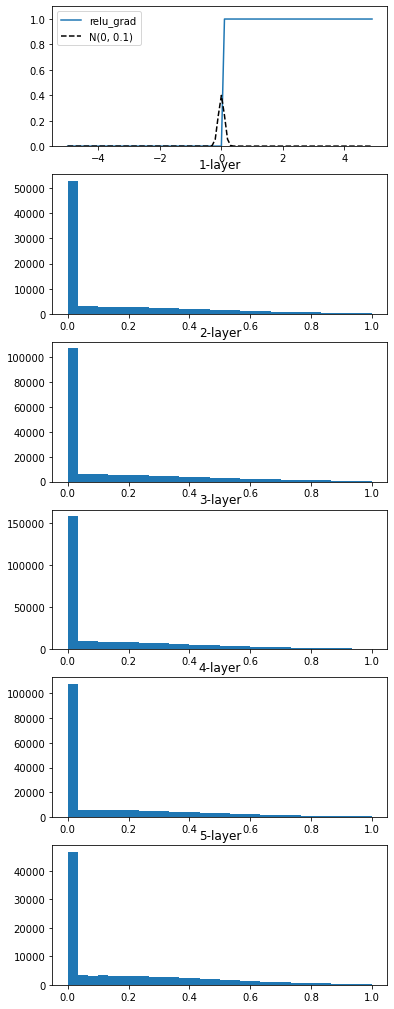

In [4]:
###############################################
# アクティベーション（活性化関数後の出力値）分布 #
# パターン4:Heの初期値                         #
###############################################

import sys, os
from pathlib import Path
sys.path.append(os.path.join(os.path.join(Path().resolve(), '..'), '..'))  # 親ディレクトリの親ディレクトリのファイルをインポートするための設定
import numpy as np
import math
from matplotlib import pyplot as plt
from common.presentation.functions import relu, relu_grad
import common.presentation.debug as debug

debug.isDebugMode = False

std  = 0.1                                 # 標準偏差
x = np.random.randn(1000, 100)              # 1000*100のndarrayを生成(100次元のデータを1000個生成)
debug.debugprt(x.shape, "x.shape")
node_num = np.array([100,200,300,200,100])  # 各中間層のノード数
hidden_layer_size = 5                       # 中間層の数
activations = {}                            # アクティベーションを格納
w = {}

######################### フォワード #########################
for i in range(hidden_layer_size):
    if i == 0:
        # 比較用
        # w = np.random.randn(x.shape[1], node_num[i]) * std  # 標準偏差固定
        # w = np.random.randn(x.shape[1], node_num[i]) / np.sqrt(x.shape[0])  # Xavierの初期値:前層のノード数の平方根で除する
        # 正規分布N(0, np.sqrt(2/x.shape[0]))に従う重みを生成
        w = np.random.randn(x.shape[1], node_num[i]) * (np.sqrt(2 / x.shape[0]))  # Heの初期値:前層のノード数の平方根で除する
    else:
        # 2層目以降は前層のアクティベーションを取得
        x = activations[i-1]
        # 比較用
        # w = np.random.randn(node_num[i-1], node_num[i]) * std  # 標準偏差固定
        # w = np.random.randn(node_num[i-1], node_num[i])  / np.sqrt(node_num[i-1])  # Xavierの初期値:前層のノード数の平方根で除する
        # 正規分布N(0, 2/np.sqrt(node_num[i]))に従う重みを生成
        w = np.random.randn(node_num[i-1], node_num[i]) * (np.sqrt(2 / node_num[i-1]))  # Heの初期値:前層のノード数の平方根で除する

    # 重み付き線形和を計算
    z = np.dot(x, w)
    # アクティベーションを計算
    a = relu(z)
    # アクティベーションを格納
    activations[i] = a

##################### ↓↓↓ グラフ描画 ↓↓↓ ######################

################# ReLU関数と初期値の分布 #################
plt.figure(figsize=(6,3*(1+len(activations))))

def normal(x, mu=0, std=1):
    return np.exp(-(x-mu)**2/(2*std**2)) / np.sqrt(2*np.pi)

x = np.arange(-5.0, 5.0, 0.1)
y1 = relu_grad(x)
y2 = normal(x,std=std)
plt.subplot(1+len(activations), 1, 1)
plt.plot(x, y1, label='relu_grad')
plt.plot(x, y2, 'k--', label=f'N(0, {std})')
plt.legend()
plt.ylim(0, 1.1)

######################## ヒストグラム ########################
for i, a in activations.items():
    plt.subplot(1+len(activations), 1, i+2)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

## Batch Normalization

* 重みの初期値問題では、初期値がアクティベーション分布の広がり（さらに言えば学習の精度）に影響することを確認した。
* 「そもそも強制的にアクティベーション分布の広がりをコントロールすればいいのでは？」というアイデアがベースとなっている。
* 2015年に提案され、（本書の出版当時では）比較的新しい手法だが、多く使われコンペで優秀成績を残したものにも用いられている。
* 特徴
    - 学習が速く進む（学習係数を大きく設定できる）
    - 初期値にそれほど依存しない
    - 過学習を抑制できる
* Batch Normalizationレイヤという正規化を行う層を追加して実現する。
* 正規化はミニバッチ単位に行い、ミニバッチのデータの分布が標準正規分布に従うように行う：<br>

### BatchNormレイヤのBackward

参考：https://qiita.com/t-tkd3a/items/14950drm55f7a3095600

![](BatchNorm.jpg)

### BatchNormの正規化方法

* 学習時にはバッチごとの平均と分散を使う
* 予測時には学習時に準備した平均と分散を使う

* 平均
$$ \rm{runningMean}_{n} = \rm{momentum} * \rm{runningMmean}_{n-1} + (1- \rm{momentum} ) * \mu \ \ \ ( \mu はバッチ平均)$$
* 分散
$$ \rm{runningMean}_{n} = \rm{momentum} * \rm{runningMmean}_{n-1} + (1- \rm{momentum} ) * \sigma^{2} \ \ \ ( \sigma^{2} はバッチ分散)$$

momentumは更新率をコントロールする係数

MACDに用いられるEMA(指数平滑移動平均)と同じような移動平均を使用して直近の値の重みが大きくなっている。


## Weight decay （荷重減衰）

重みが大きな値を取るほど過学習が起こりやすいため、損失関数に正則化項を加えて重みが大きくなることを防ぐ。<br>
すなわち、$E$を損失関数とするとき
$$ L = E + \dfrac{1}{2} \lambda{||W||}^2$$
を最小化する。

$\lambda$は正則化パラメータで、大きな値を設定するほど重みが大きくなることに対するペナルティが大きくなる。

なお、ぜろつくでは正則化項の${||W||}^2$はゼロつくでは中間層も含めた全レイヤの重みを足し上げている。